In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, activations
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import sklearn as sk
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import itertools
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Import Data

The dataset used for our project is imported here.

In [2]:
df = pd.read_csv("../labeled_data.csv")

The structure of the imported data can be seen in the following cell.

The dataset selected for training contains 7 columns and almost 24.783 rows of data. Hereby are the text passages differentiated into 3 different classes: hate_speech, offensive_language or neither. This classification was conducted by volunteers of CrowdFlower. The predominant predicted class is stored in the column "class". 

In [3]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Tokenizer

In order to process the data later on, all Tweets are tokenized. This transforms the Tweet into a list of single words contained in the original Tweet.

The Tweets are stored in the dataframe df (column "tweet")

In [4]:
#Split String for each word
def toLowerAndSplit(tweet):
    tweet = tweet.lower()
    tweet = tweet.split()
    return tweet

The method defined splits every word and moves it to lower cases, so the individual words contained within the tweet become individual analyzable.

In [5]:
tweets = pd.DataFrame(df["tweet"].apply(toLowerAndSplit))

In [6]:
tweets

,tweet
0,"[!!!, rt, @mayasolovely:, as, a, woman, you, s..."
1,"[!!!!!, rt, @mleew17:, boy, dats, cold...tyga,..."
2,"[!!!!!!!, rt, @urkindofbrand, dawg!!!!, rt, @8..."
3,"[!!!!!!!!!, rt, @c_g_anderson:, @viva_based, s..."
4,"[!!!!!!!!!!!!!, rt, @shenikaroberts:, the, shi..."
...,...
24778,"[you's, a, muthaf***in, lie, &#8220;@lifeaskin..."
24779,"[you've, gone, and, broke, the, wrong, heart, ..."
24780,"[young, buck, wanna, eat!!.., dat, nigguh, lik..."
24781,"[youu, got, wild, bitches, tellin, you, lies]"


# Visual Overview

In order to gain a first impression of the used dataset, we counted the number of times a specific word is present in the observed Tweets.

In [7]:
#Create a list containing all words mentioned in tweets
all_words = list(itertools.chain(*tweets["tweet"]))

## Count Words

In [8]:
# Count of every word
word_counts = Counter(all_words)

df_uncleaned = pd.DataFrame(word_counts.most_common(10))


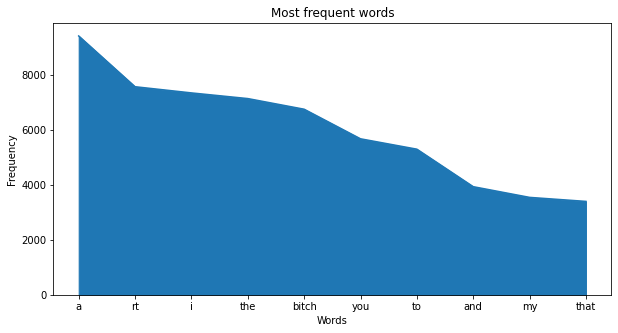

In [9]:
df_uncleaned.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_uncleaned.index)), df_uncleaned[0])
plt.show()

This graph is showing the most used words in the tweets of the dataset. It is noticeable, that many of the most frequent words are stopwords like "a", "i", "the", which are not important for our further analysis.

## Remove stopwords
To gain more substantial insight into the data, these stopwords have to be removed. These words construct the grammatical dependencies of the english language, but do not contain any relevant information to determine hate speech.

## Remove Tags
Twitter tags such as @genericUser do not give further insight for hate speech detection purposes. Thus, they have to be removed.

## Remove Links
Similar to stopwords and Tags, links do not add meaningfull information to the purpose of hate speech --> remove

## Remove Twitter Elements
The Tweets can contain Twitter excluvsive information, such as "rt", "rts" or "retweet". These formulations do not add any meaning to the Tweets content and have therefore to be removed.

In [10]:
#Downloads list with stopwords of the english language
#Uncomment if nltk stopwords were not downloaded yet
#nltk.download('stopwords')

In [11]:
#Define variable wit henglish stopwords
sw = stopwords.words("english")
twitter_elements = ["rt", "rts", "retweet"]
i_elements = ["i", "i'm", "im", "iam"] # remove u?
most_common = word_counts.most_common()


#Clean most frequent words by removing unwanted words for visualisation
def removeNoiseWordCount(word_list):
    cleaned_word_list = []
    for element in word_list:
        #Removes words contained in stopwords
        if element[0] not in sw:
            #Removes words with @ --> remove Tags
            if "@" not in element[0]: 
                #Removes words containing http --> links
                if "http" not in element[0]:
                    hasTwitterElement = False
                    hasIElement = False
                    for tw in twitter_elements:
                        if tw in element:
                            hasTwitterElement = True
                    for ie in i_elements:
                        if ie in element:
                            hasIElement = True
                    if hasTwitterElement == False and hasIElement == False:
                        cleaned_word_list.append(element)

    return cleaned_word_list

In [12]:
cleaned_word_list_complete = removeNoiseWordCount(most_common)

In [13]:
df_cleaned_top10 = pd.DataFrame(cleaned_word_list_complete[:10])

In [14]:
df_cleaned_top10

,0,1
0,bitch,6749
1,bitches,2677
2,like,2674
3,hoes,1977
4,pussy,1731
5,hoe,1483
6,ass,1472
7,get,1413
8,fuck,1311
9,got,1275


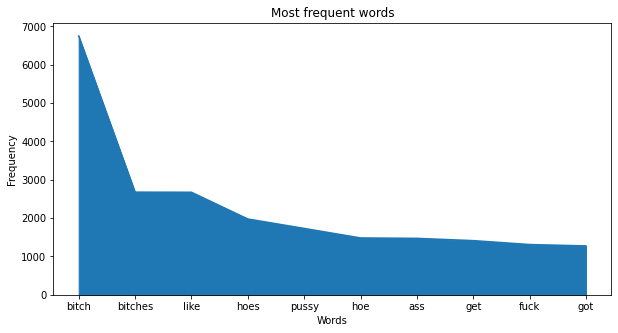

In [15]:
df_cleaned_top10.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_cleaned_top10.index)), df_cleaned_top10[0])
plt.show()

It is noticeable, that certain words appear both in a singualar as well as their plural form (for example bitch and bitches/ hoe and hoes). This could impare the results of our models later on. To counter this, word stems have to be extracted for each word after the data was preprocessed.  

# Data Preprocessing

Here the Tweets themselfes are preprocessed in a similar fashion compared to our visualisation efforts. Since the Data structure is slightly different, we opted to design a new function.

In [16]:
def removeNoiseFromTweet(word_list):
    cleaned_word_list = []
    for element in word_list:
        for word in element:
            #Removes words contained in stopwords
            if word not in sw:
                #Removes words with @ --> remove Tags
                if "@" not in word: 
                    #Removes words containing http --> links
                    if "http" not in word:
                        hasTwitterElement = False
                        hasIElement = False
                        #Removes Twitter exclusive Words (retweet/ rt...) 
                        for tw in twitter_elements:
                            if tw in word:
                                hasTwitterElement = True
                        for ie in i_elements:
                            if ie in word:
                                hasIElement = True
                        if hasTwitterElement == False & hasIElement == False:
                            #Remove special characters from string
                            cleaned_word = ""
                            cleaned_word = "".join(character for character in word if character.isalnum())
                            
                            if cleaned_word != "":
                                if cleaned_word == "":
                                    print("cleaned_word")
                                cleaned_word_list.append(cleaned_word)
        return cleaned_word_list

In [17]:
#Apply the removeNoiseFromTweet function with axis = 1 --> compute for every row
cleaned_words_df = tweets.apply(func=removeNoiseFromTweet, axis=1)

In [18]:
#Cleaned pandas series element 
cleaned_words_df

0        [woman, complain, cleaning, house, amp, man, a...
1        [boy, dats, coldtyga, dwn, bad, cuffin, dat, h...
2           [dawg, ever, fuck, bitch, cry, confused, shit]
3                                     [look, like, tranny]
4        [shit, hear, might, true, might, faker, bitch,...
                               ...                        
24778    [yous, muthafin, lie, right, tl, trash, 8230, ...
24779    [gone, broke, wrong, baby, drove, redneck, crazy]
24780    [young, buck, wanna, eat, dat, nigguh, like, a...
24781             [youu, got, wild, bitches, tellin, lies]
24782    [ruffled, ntac, eileen, dahlia, beautiful, col...
Length: 24783, dtype: object

# Word Stems

To ensure high data quality, we should extract the word stems for each word as described above.(e.g. in plot above: bitch/ bitches currently are seperate entities at this point). 

In [19]:
#Downloads list with word stems of words in the english language
#Remove Comment when running the first time
#nltk.download('punkt')

In [20]:
stemmer = PorterStemmer()
def stemWords(tweet):
    word_stems = []
    for word in tweet:
        
        word_stems.append(stemmer.stem(word))
        
    return word_stems

In [21]:
word_stems = cleaned_words_df.apply(stemWords)

Words contained in the Tweets now only appear with their word stem. This can be seen in the output below.

In [22]:
word_stems

0        [woman, complain, clean, hous, amp, man, alway...
1        [boy, dat, coldtyga, dwn, bad, cuffin, dat, ho...
2             [dawg, ever, fuck, bitch, cri, confus, shit]
3                                     [look, like, tranni]
4        [shit, hear, might, true, might, faker, bitch,...
                               ...                        
24778    [you, muthafin, lie, right, tl, trash, 8230, n...
24779    [gone, broke, wrong, babi, drove, redneck, crazi]
24780    [young, buck, wanna, eat, dat, nigguh, like, a...
24781                [youu, got, wild, bitch, tellin, lie]
24782    [ruffl, ntac, eileen, dahlia, beauti, color, c...
Length: 24783, dtype: object

To visualise this effect, we again opted to plot the data to see the difference more clearly.

In [23]:
#Create a list containing all words mentioned in tweets
stem_words = list(itertools.chain(*word_stems))

In [24]:
# Count of every word
word_counts_stem = Counter(stem_words)

df_stem = pd.DataFrame(word_counts_stem.most_common(10))


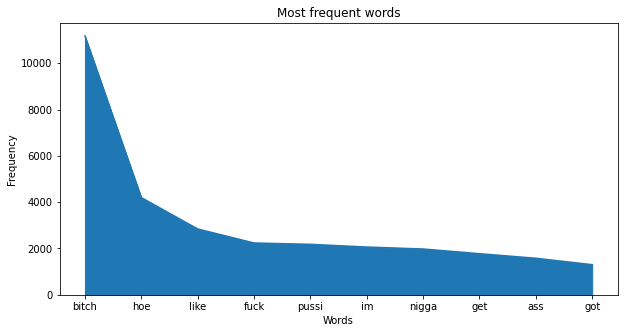

In [25]:
df_stem.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_stem.index)), df_stem[0])
plt.show()

## Word Count for Hate speech
Here we compare the average length of Hate/ Offensive/ Neither Tweets to gain further insight

In [26]:
index_hate = df[df["class"] == 0]["tweet"].index
index_offensive = df[df["class"] == 1]["tweet"].index
index_neither = df[df["class"] == 2]["tweet"].index


hate_tweets = word_stems.iloc[index_hate]
offensive_tweets = word_stems.iloc[index_offensive]
neither_tweets = word_stems.iloc[index_neither]

In [27]:
def calculateLength(data):
    data_length = len(data)
    length_count = 0
    for element in data:
        length_count = length_count + len(element)
        
    result = length_count/data_length
    return result
    
length_hate = calculateLength(hate_tweets)
length_offensive = calculateLength(offensive_tweets)
length_neither = calculateLength(neither_tweets)

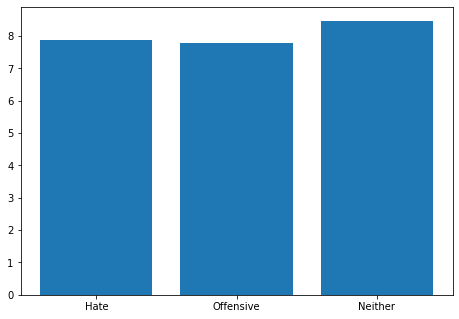

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
categories = ["Hate", "Offensive", "Neither"]
length = [length_hate, length_offensive, length_neither]
ax.bar(categories,length)

plt.show()

# Models

In [29]:
#change elements of column from list to string
def makeString(column):
    result = " ".join(column)
    return result

In [30]:
word_stems_text = word_stems.apply(makeString)

In [31]:
#split into train and test set
X_train, X_test, y_train, y_test = train_test_split(word_stems_text, df["class"], test_size=0.2, random_state=10)

In [32]:
custom_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print(custom_weights)

[5.77176128 0.42983198 1.99899173]


D:\Tools\Anaconda\envs\Text Mining\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=700      0
3015     1
9011     0
10395    1
8422     2
        ..
9372     0
7291     1
17728    1
7293     2
17673    1
Name: class, Length: 19826, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [33]:
#The following function creates a dictionary with the customized weights.
def custom_weights_to_dictionary(weights):
    dic = {}
    for i in range(len(weights)):
        dic[i] = weights[i]
    return dic

weights = custom_weights_to_dictionary(custom_weights)
print(weights)

{0: 5.771761280931587, 1: 0.4298319783197832, 2: 1.9989917322040733}


## Logistic Regression

In [34]:
#Benötigt von Logistic Regression
tfid = TfidfVectorizer(lowercase=False)
x_train_vec = tfid.fit_transform(X_train)
x_test_vec = tfid.transform(X_test)

In [35]:
x_train_vec

<19826x17874 sparse matrix of type '<class 'numpy.float64'>'
	with 147811 stored elements in Compressed Sparse Row format>

In [36]:
#When C < 1 --> better results
lr = LogisticRegression(solver="liblinear", penalty="l2", C=1)

In [37]:
lr.fit(x_train_vec, y_train)

LogisticRegression(C=1, solver='liblinear')

In [38]:
y_predict = lr.predict(x_test_vec)

              precision    recall  f1-score   support

           0       0.64      0.14      0.23       285
           1       0.90      0.98      0.94      3815
           2       0.88      0.77      0.82       857

    accuracy                           0.89      4957
   macro avg       0.81      0.63      0.66      4957
weighted avg       0.88      0.89      0.88      4957



<Figure size 216x216 with 0 Axes>

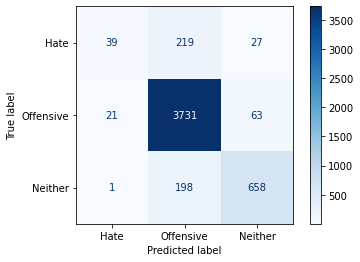

In [39]:
print(classification_report(y_test, y_predict))

labels = ["Hate", "Offensive", "Neither"]
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

# Naive Bayes

In [40]:
tfid = TfidfVectorizer(lowercase=False)
x_train_vec_nn = tfid.fit_transform(X_train)
#x_test_vec = tfid.transform(X_test)

In [41]:
x_train_vec_nn

<19826x17874 sparse matrix of type '<class 'numpy.float64'>'
	with 147811 stored elements in Compressed Sparse Row format>

In [42]:
#If fit_prior = False, strong overfitting in class "Hate"
nb = MultinomialNB(alpha=0, fit_prior=True)
nb.fit(x_train_vec_nn, y_train)  

D:\Tools\Anaconda\envs\Text Mining\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


MultinomialNB(alpha=0)

In [43]:
y_predict = nb.predict(x_test_vec)

              precision    recall  f1-score   support

           0       0.40      0.09      0.15       285
           1       0.84      0.95      0.89      3815
           2       0.67      0.44      0.53       857

    accuracy                           0.81      4957
   macro avg       0.64      0.49      0.52      4957
weighted avg       0.78      0.81      0.79      4957



<Figure size 216x216 with 0 Axes>

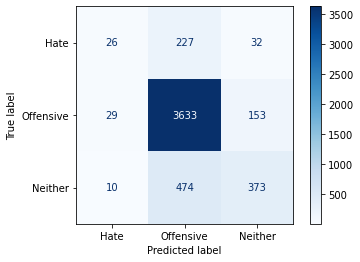

In [44]:
print(classification_report(y_test,y_predict))
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

## Random Forest

In [45]:
#If n_esimators higher --> lower recall value for Hate Speech
rfc = RandomForestClassifier(n_estimators = 3, criterion="gini", class_weight=weights, verbose=1, n_jobs = 24)

rfcModel = rfc.fit(x_train_vec, y_train)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   3 out of   3 | elapsed:    0.1s finished


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.37      0.24      0.29       285
           1       0.91      0.95      0.93      3815
           2       0.79      0.73      0.76       857

    accuracy                           0.87      4957
   macro avg       0.69      0.64      0.66      4957
weighted avg       0.86      0.87      0.86      4957



<Figure size 216x216 with 0 Axes>

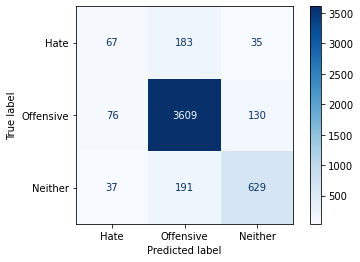

In [46]:
pred = rfcModel.predict(x_test_vec)

print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

# Data for Neural Networks

In order to train neural networks, the data format has to be altered.

In [47]:
train_tweet = X_train
test_tweet = X_test

tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_tweet)
train_tweet = tokenizer.texts_to_sequences(train_tweet)
test_tweet = tokenizer.texts_to_sequences(test_tweet)

train_tweet = pad_sequences(train_tweet, maxlen=27)
test_tweet = pad_sequences(test_tweet, maxlen=27)

For classification purposes, the target data is refactored: While it previously was a single number (0,1,2), it now is an array with a length of three, where each element represents one class (hate, offensive, neither).

In [48]:
encoder = LabelEncoder()

y_train_categorical = encoder.fit_transform(y_train)
y_train_categorical = to_categorical(y_train) 

y_test_categorical = encoder.fit_transform(y_test)
y_test_categorical = to_categorical(y_test) 

In [49]:
epoch = 50
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 4, factor=0.7)

callbacks=[earlyStop]

# Dense Neural Network

In [50]:
def model_1():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 256, input_length = 27))
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

train_model_1 = model_1()

history_model_1 = train_model_1.fit(
           train_tweet,
           y_train_categorical,
           validation_data=(test_tweet,y_test_categorical),
           epochs= epoch,
           shuffle=True,
           callbacks=callbacks)

Epoch 1/50
620/620 [==============================] - 5s 7ms/step - loss: 0.5061 - accuracy: 0.8232 - val_loss: 0.3432 - val_accuracy: 0.8884
Epoch 2/50
620/620 [==============================] - 4s 7ms/step - loss: 0.3033 - accuracy: 0.9017 - val_loss: 0.2960 - val_accuracy: 0.8967
Epoch 3/50
620/620 [==============================] - 4s 7ms/step - loss: 0.2295 - accuracy: 0.9226 - val_loss: 0.3197 - val_accuracy: 0.8947
Epoch 4/50
620/620 [==============================] - 4s 6ms/step - loss: 0.1784 - accuracy: 0.9379 - val_loss: 0.3382 - val_accuracy: 0.8901
Epoch 5/50
620/620 [==============================] - 4s 7ms/step - loss: 0.1354 - accuracy: 0.9521 - val_loss: 0.3968 - val_accuracy: 0.8892
Epoch 6/50
620/620 [==============================] - 4s 7ms/step - loss: 0.1128 - accuracy: 0.9614 - val_loss: 0.4187 - val_accuracy: 0.8856
Epoch 7/50
620/620 [==============================] - 4s 7ms/step - loss: 0.0945 - accuracy: 0.9681 - val_loss: 0.5239 - val_accuracy: 0.8677


To extract the class of the prediction values, a function transforms the place of the highest number into an integer value. Example: If the highest number is at the beginning of the prediction array, the following function will return 0 for this instance.

In [51]:
predictions = train_model_1.predict(test_tweet)

def checkPrediction(pred):
    cleaned_prediction = []
    biggest_number = 0
    to_insert = 0
    for element in pred:
        for count in range(len(element)):
            if element[count] > biggest_number:
                biggest_number = element[count]
                to_insert = count
        biggest_number = 0
        cleaned_prediction.append(to_insert)
        to_insert = 0
    return cleaned_prediction

pred_cleaned = checkPrediction(predictions)
y_test_cleaned = checkPrediction(y_test_categorical)

              precision    recall  f1-score   support

           0       0.59      0.19      0.29       285
           1       0.93      0.95      0.94      3815
           2       0.80      0.89      0.84       857

    accuracy                           0.90      4957
   macro avg       0.77      0.68      0.69      4957
weighted avg       0.89      0.90      0.88      4957



<Figure size 216x216 with 0 Axes>

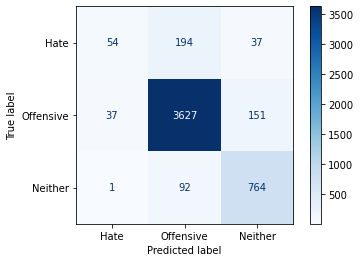

In [52]:
print(classification_report(y_test_cleaned, pred_cleaned))
cm = confusion_matrix(y_test_cleaned, pred_cleaned)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

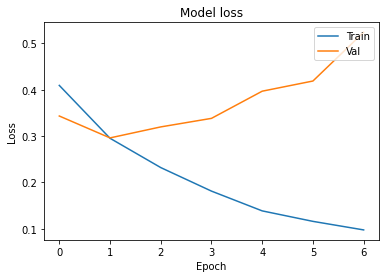

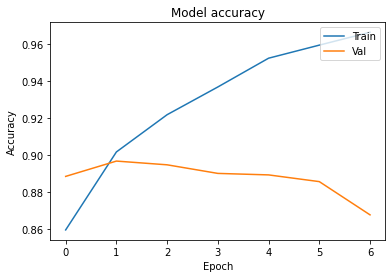

In [53]:
plt.plot(history_model_1.history['loss'])
plt.plot(history_model_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history_model_1.history['accuracy'])
plt.plot(history_model_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Custom Weights

In [54]:
def model_2():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = 27))
    model.add(keras.layers.Dense(256, activation='tanh'))
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(128, activation='tanh'))
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(64, activation='tanh'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

train_model_2 = model_2()
history_model_2 = train_model_2.fit(
                   train_tweet,
                   y_train_categorical,
                   validation_split=0.2,
                   class_weight=weights,
                   epochs= epoch,
                   shuffle=True,
                   callbacks=callbacks)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
496/496 [==============================] - 5s 8ms/step - loss: 1.0763 - accuracy: 0.4174 - val_loss: 0.6413 - val_accuracy: 0.8018
Epoch 2/50
496/496 [==============================] - 4s 7ms/step - loss: 0.6908 - accuracy: 0.6990 - val_loss: 0.5795 - val_accuracy: 0.7758
Epoch 3/50
496/496 [==============================] - 4s 8ms/step - loss: 0.4053 - accuracy: 0.8332 - val_loss: 0.6458 - val_accuracy: 0.7569
Epoch 4/50
496/496 [==============================] - 4s 8ms/step - loss: 0.3228 - accuracy: 0.8570 - val_loss: 0.7038 - val_accuracy: 0.7489
Epoch 5/50
496/496 [==============================] - 4s 7ms/step - loss: 0.2634 - accuracy: 0.8819 - val_loss: 0.7324 - val_accuracy: 0.7521
Epoch 6/50
496/496 [==============================] - 4s 7ms/step - loss: 0.2424 - accuracy: 0.8900 - val_loss: 0.8223 - val_accuracy: 0.7489
Epoch 7/50

              precision    recall  f1-score   support

           0       0.21      0.66      0.32       285
           1       0.95      0.80      0.87      3815
           2       0.77      0.79      0.78       857

    accuracy                           0.79      4957
   macro avg       0.65      0.75      0.66      4957
weighted avg       0.88      0.79      0.82      4957



<Figure size 216x216 with 0 Axes>

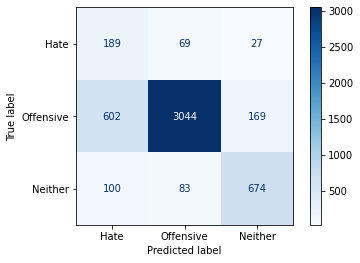

In [55]:
predictions = train_model_2.predict(test_tweet)

pred_cleaned = checkPrediction(predictions)

print(classification_report(y_test_cleaned, pred_cleaned))
cm = confusion_matrix(y_test_cleaned, pred_cleaned)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

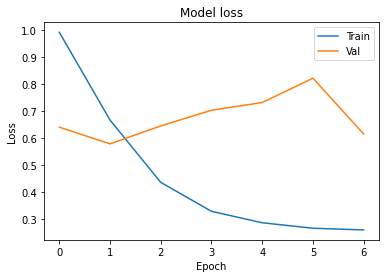

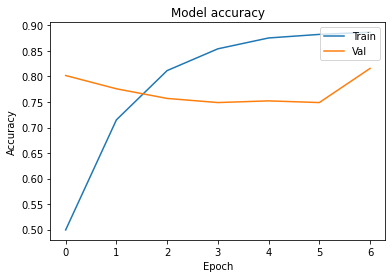

In [56]:
plt.plot(history_model_2.history['loss'])
plt.plot(history_model_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history_model_2.history['accuracy'])
plt.plot(history_model_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# CNN

In [57]:
def model_3():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = 27))
    model.add(keras.layers.Conv1D(128, 5, activation='relu'))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

train_model_3 = model_3()
history_model_3 = train_model_3.fit(
                   train_tweet,
                   y_train_categorical,
                   validation_split=0.2,
                   class_weight=weights,
                   epochs=epoch,
                   shuffle=True,
                   callbacks=callbacks)

Epoch 1/50
496/496 [==============================] - 6s 7ms/step - loss: 1.0100 - accuracy: 0.4074 - val_loss: 0.6084 - val_accuracy: 0.8386
Epoch 2/50
496/496 [==============================] - 3s 6ms/step - loss: 0.4941 - accuracy: 0.7900 - val_loss: 0.5826 - val_accuracy: 0.7993
Epoch 3/50
496/496 [==============================] - 3s 6ms/step - loss: 0.3048 - accuracy: 0.8623 - val_loss: 0.4617 - val_accuracy: 0.8371
Epoch 4/50
496/496 [==============================] - 3s 6ms/step - loss: 0.2265 - accuracy: 0.8928 - val_loss: 0.6089 - val_accuracy: 0.7847
Epoch 5/50
496/496 [==============================] - 3s 6ms/step - loss: 0.1667 - accuracy: 0.9206 - val_loss: 0.5656 - val_accuracy: 0.8452
Epoch 6/50
496/496 [==============================] - 3s 6ms/step - loss: 0.1187 - accuracy: 0.9429 - val_loss: 0.6485 - val_accuracy: 0.8162
Epoch 7/50
496/496 [==============================] - 3s 6ms/step - loss: 0.1006 - accuracy: 0.9507 - val_loss: 0.7559 - val_accuracy: 0.8298
Epoch 

              precision    recall  f1-score   support

           0       0.27      0.56      0.37       285
           1       0.95      0.86      0.90      3815
           2       0.79      0.86      0.82       857

    accuracy                           0.84      4957
   macro avg       0.67      0.76      0.70      4957
weighted avg       0.88      0.84      0.86      4957



<Figure size 216x216 with 0 Axes>

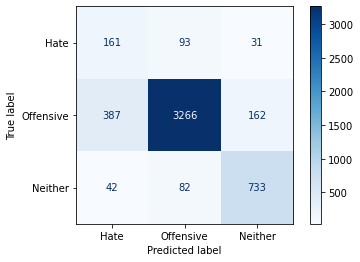

In [58]:
predictions = train_model_3.predict(test_tweet)

pred_cleaned = checkPrediction(predictions)

print(classification_report(y_test_cleaned, pred_cleaned))
cm = confusion_matrix(y_test_cleaned, pred_cleaned)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

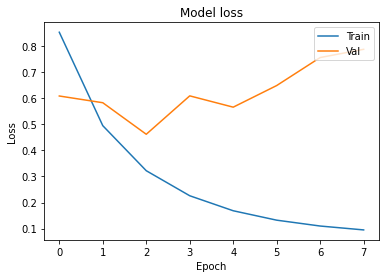

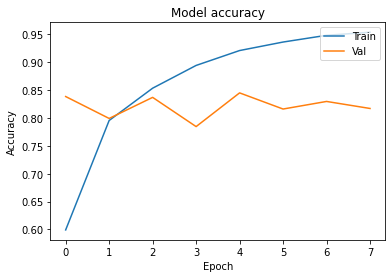

In [59]:
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history_model_3.history['accuracy'])
plt.plot(history_model_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Dropout Modell

In [ ]:
def model_dropout():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = 27))
    model.add(keras.layers.Dense(256, activation='selu'))
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(256, activation='selu'))
    model.add(keras.layers.Dropout(0.7))    
    model.add(keras.layers.Dense(256, activation='selu'))
    model.add(keras.layers.Dropout(0.7)) 
    model.add(keras.layers.Dense(256, activation='selu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.7))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='BinaryCrossentropy', optimizer='Adamax', metrics=['accuracy'])
    return model

train_model_4 = model_dropout()
history_model_4 = train_model_4.fit(
                   train_tweet,
                   y_train_categorical,
                   validation_split=0.2,
                   class_weight=weights,
                   epochs= epoch,
                   shuffle=True,
                   callbacks=callbacks)

Epoch 1/50
496/496 [==============================] - 5s 9ms/step - loss: 0.7495 - accuracy: 0.3337 - val_loss: 0.6425 - val_accuracy: 0.1520
Epoch 2/50
385/496 [======================>.......] - ETA: 1s - loss: 0.6676 - accuracy: 0.3722

In [ ]:
predictions = train_model_4.predict(test_tweet)

pred_cleaned = checkPrediction(predictions)

print(classification_report(y_test_cleaned, pred_cleaned))
cm = confusion_matrix(y_test_cleaned, pred_cleaned)

plt.figure(figsize=(3,3))
ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap='Blues', xticks_rotation=0)
plt.grid(False)
plt.show()

In [ ]:
plt.plot(history_model_4.history['loss'])
plt.plot(history_model_4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(history_model_4.history['accuracy'])
plt.plot(history_model_4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Findings

In [ ]:
len(df[df["class"] == 0])

In [ ]:
len(df[df["class"] == 1])

In [ ]:
len(df[df["class"] == 2])